In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import dtc_correction

target_col = '2022_1_true'
reference_cols = ['cv', 'sk', 'ks', 'co', 'vc', 'cmd', 'pmd', 'ac', 'as',
       'icp', 'com', 'niu', 'dno', 'nad', 'csc', 'csnc', 'cid', 'lt', 'sc',
       'ns', 'ocnpa', 'csns']

#df1 = pd.read_csv('df1_5k_sample.csv')
#df2 = pd.read_csv('df2_100k_sample.csv')

test = pd.read_csv('monthly_testset_12_2022_v1.csv.gz', compression='gzip')
pop = pd.read_csv('pop_12_14_gt_churn.csv')

<Axes: >

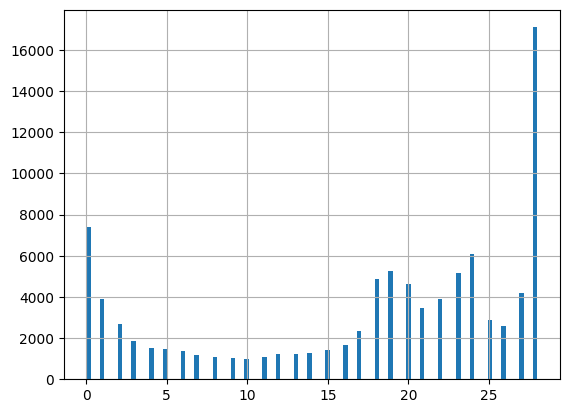

In [24]:
#demonstrate bias
test.cmd.hist(bins=100)

<Axes: >

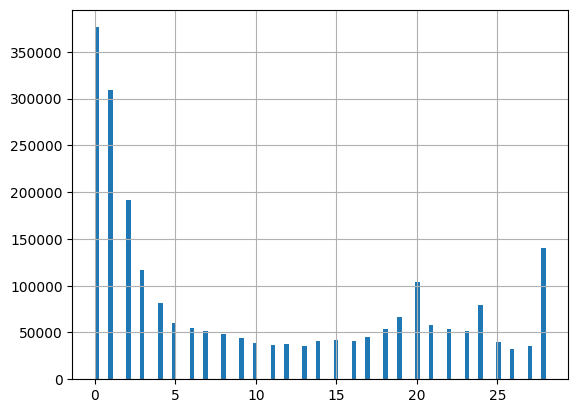

In [25]:
pop.cmd.hist(bins=100)

In [36]:
import imp
imp.reload(dtc_correction)
r = dtc_correction.Resampler()

#train decision tree
r.train_dt(dataset=test, target_col=target_col, reference_cols=reference_cols)

pop.fillna(0, inplace=True)
pop_pred = r.resample_from_dataset(reference_dataset=pop, orig_reference_cols=reference_cols)

starting Gini impurity: 0.6634598782248707
ending Gini impurity: 0.2921026091619754
mean accuracy of resulting DTC on full dataset: 0.7888395821694723


In [41]:
#initial dataset (biased)
test['2022_1_true'].value_counts(normalize=True)

2    0.480126
3    0.229090
1    0.222028
4    0.065015
5    0.003742
Name: 2022_1_true, dtype: float64

In [40]:
#bias-corrected dataset
pop_pred.pred_target.value_counts(normalize=True)

2    0.421262
1    0.405400
3    0.167223
4    0.005459
5    0.000655
Name: pred_target, dtype: float64

In [39]:
#true population value
pop['2022_1_true'].value_counts(normalize=True)

3    0.739665
1    0.209443
2    0.046931
4    0.002782
5    0.001179
Name: 2022_1_true, dtype: float64

### Toy datasets

In [87]:
import numpy as np

#create initial dataset
x1 = np.random.randn(1000)
x2 = np.random.randn(1000)
x3 = np.random.randn(1000)
y = np.rint(x1 + x2 + x3 + (np.random.randn(1000) * 0.01))

df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x2, 'y': y})

<Axes: >

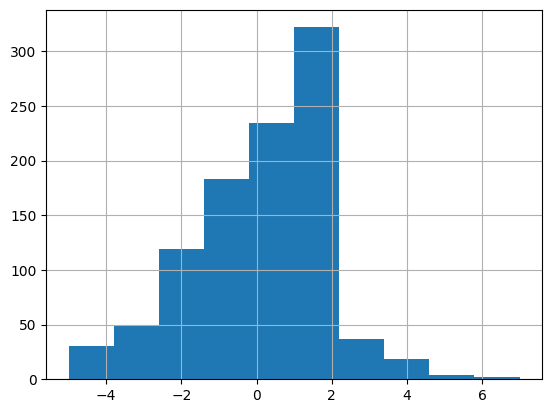

In [88]:
df.y.hist()

In [89]:
#create biased sample
weights = np.exp(df.y)
df_bias = df.sample(frac=0.1, weights=weights)

In [90]:
weights

0      1.000000
1      0.367879
2      0.367879
3      7.389056
4      2.718282
         ...   
995    2.718282
996    7.389056
997    2.718282
998    1.000000
999    1.000000
Name: y, Length: 1000, dtype: float64

<Axes: >

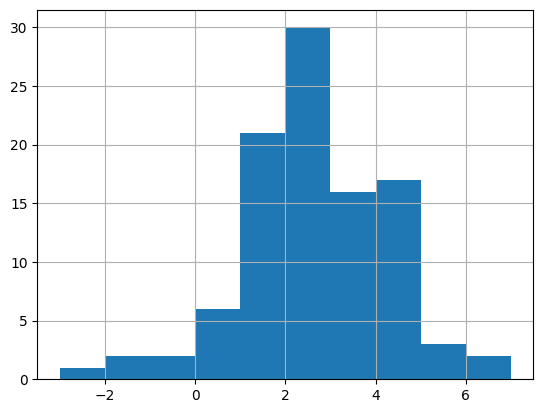

In [91]:
df_bias.y.hist()

In [92]:
df.y.describe()

count    1000.000000
mean       -0.040000
std         1.770179
min        -5.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: y, dtype: float64

In [93]:
df_bias.y.describe()

count    100.000000
mean       2.160000
std        1.649732
min       -3.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: y, dtype: float64

In [118]:
#now correcting the bias using dtc correction
import imp
imp.reload(dtc_correction)
r = dtc_correction.Resampler()

#train decision tree
r.train_dt(dataset=df_bias, target_col='y', reference_cols=['x1', 'x2', 'x3'])
pred = r.resample_from_dataset(reference_dataset=df, orig_reference_cols=['x1', 'x2', 'x3'])

c:\Users\jdunning\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-1.0.1-py3.9-win-amd64.egg\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


starting Gini impurity: 0.8076000000000001
ending Gini impurity: 0.4482564102564102
mean accuracy of resulting DTC on full dataset: 0.66


In [119]:
df_bias.y.value_counts(normalize=True)

2.0     0.30
1.0     0.21
4.0     0.17
3.0     0.16
0.0     0.03
5.0     0.03
-0.0    0.03
-1.0    0.02
-2.0    0.02
6.0     0.01
7.0     0.01
-3.0    0.01
Name: y, dtype: float64

In [120]:
pred.pred_target.value_counts(normalize=True)

1.0     0.311
2.0     0.211
-2.0    0.090
-0.0    0.076
-1.0    0.074
0.0     0.070
4.0     0.065
3.0     0.055
-3.0    0.041
5.0     0.004
7.0     0.002
6.0     0.001
Name: pred_target, dtype: float64

In [121]:
df.y.value_counts(normalize=True)

-0.0    0.234
 1.0    0.207
-1.0    0.183
-2.0    0.119
 2.0    0.115
-3.0    0.050
 3.0    0.037
-4.0    0.024
 4.0    0.019
-5.0    0.006
 5.0    0.004
 7.0    0.001
 6.0    0.001
Name: y, dtype: float64

In [153]:
def sum_squared_diff(d1, d2):
    s = 0
    for k in d1.keys():
        s += (d1[k] - d2[k]) ** 2
    return s

In [154]:
pred_dict = dict(pred.pred_target.value_counts(normalize=True))
true_dict = dict(df.y.value_counts(normalize=True))
bias_dict = dict(df_bias.y.value_counts(normalize=True))

for key in set(list(true_dict.keys()) + list(pred_dict.keys()) + list(bias_dict.keys())):
    if key not in pred_dict: pred_dict[key] = 0
    if key not in true_dict: true_dict[key] = 0
    if key not in bias_dict: true_dict[key] = 0

sum_squared_diff(pred_dict, true_dict)

0.174446

In [155]:
sum_squared_diff(bias_dict, true_dict)

0.19240000000000004